In [339]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy.stats import boxcox
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import set_config
set_config(transform_output = "pandas")
from sklearn.preprocessing import PowerTransformer

In [341]:
data= pd.read_csv('/Users/sarahberkin/Berkin-Data Science Capstone/diabetes.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [343]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [345]:
data['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

^^^ I will balance the dataset after I take a look at outliers

In [347]:
data[data.Outcome == '1'].T

""
Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DiabetesPedigreeFunction
Age
Outcome


In [349]:
missing_counts = data.isnull().sum()
missing_percentages = 100 * data.isnull().mean()
missing = pd.concat([missing_counts, missing_percentages], axis=1)
missing.columns=['count', '%']
missing.sort_values(by=['count'])

,count,%
Pregnancies,0,0.0
Glucose,0,0.0
BloodPressure,0,0.0
SkinThickness,0,0.0
Insulin,0,0.0
BMI,0,0.0
DiabetesPedigreeFunction,0,0.0
Age,0,0.0
Outcome,0,0.0


In [351]:
averages_by_outcome = data.groupby('Outcome')[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].mean()
averages_by_outcome.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


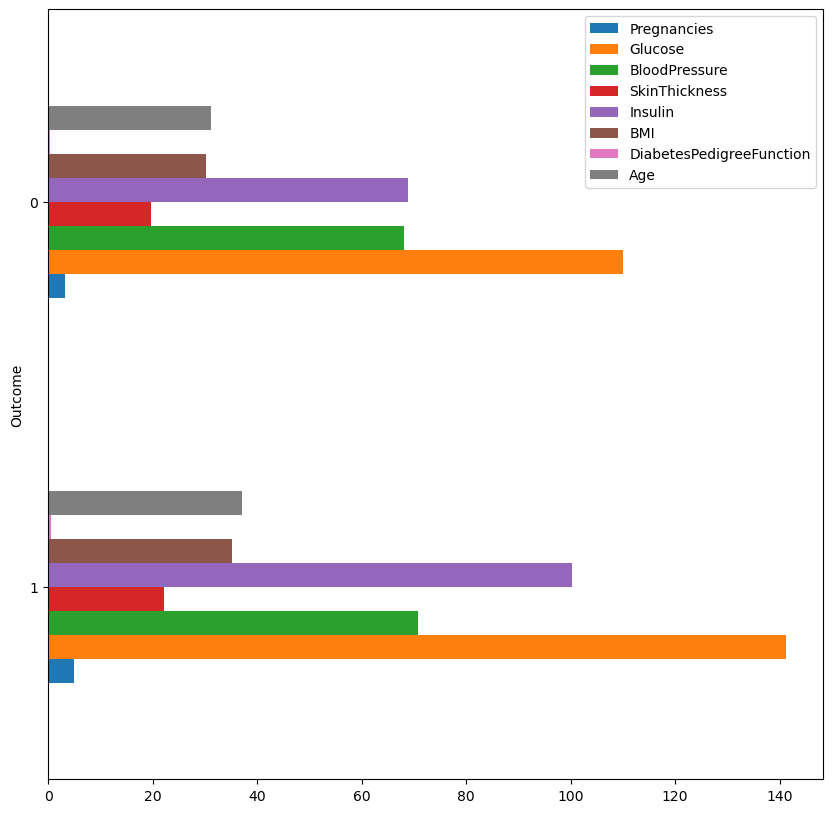

In [353]:
(averages_by_outcome.reindex(index=averages_by_outcome.mean(axis=1).sort_values(ascending=False).index).plot(kind='barh', figsize=(10,10)))
plt.show()

In [355]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


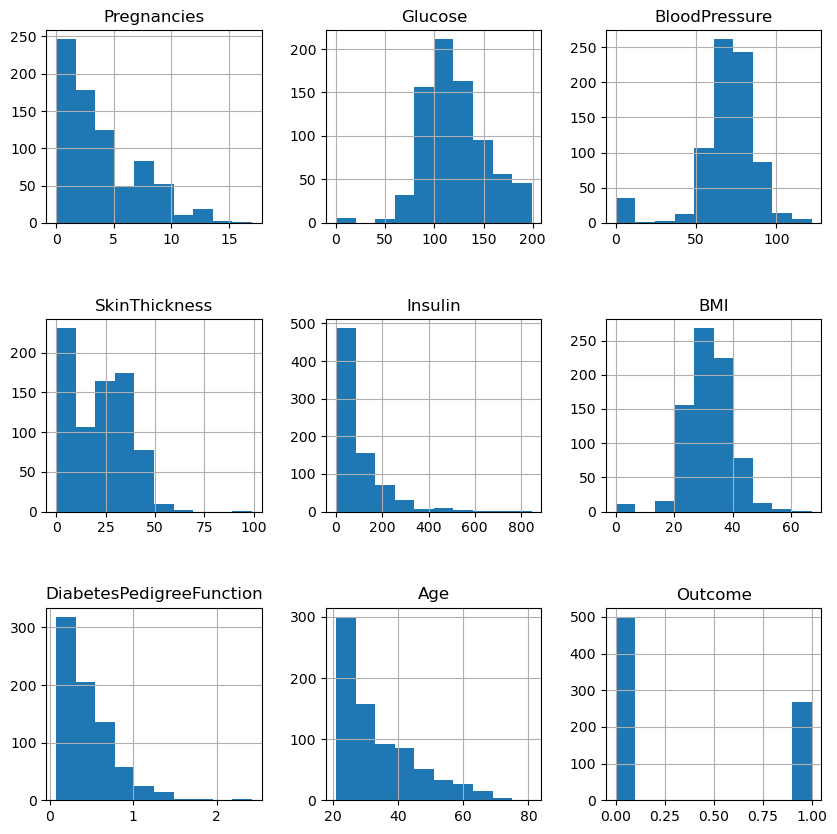

In [357]:
data.hist(figsize=(10,10))
plt.subplots_adjust(hspace=0.5);

In [359]:
data[data.Glucose < 40].T

,75,182,342,349,502
Pregnancies,1.00,1.000,1.000,5.000,6.000
Glucose,0.00,0.000,0.000,0.000,0.000
BloodPressure,48.00,74.000,68.000,80.000,68.000
SkinThickness,20.00,20.000,35.000,32.000,41.000
Insulin,0.00,23.000,0.000,0.000,0.000
BMI,24.70,27.700,32.000,41.000,39.000
DiabetesPedigreeFunction,0.14,0.299,0.389,0.346,0.727
Age,22.00,21.000,22.000,37.000,41.000
Outcome,0.00,0.000,0.000,1.000,1.000


In [361]:
data[data.BMI < 10].T

,9,49,60,81,145,371,426,494,522,684,706
Pregnancies,8.000,7.000,2.000,2.000,0.000,0.000,0.000,3.000,6.000,5.00,10.000
Glucose,125.000,105.000,84.000,74.000,102.000,118.000,94.000,80.000,114.000,136.00,115.000
BloodPressure,96.000,0.000,0.000,0.000,75.000,64.000,0.000,0.000,0.000,82.00,0.000
SkinThickness,0.000,0.000,0.000,0.000,23.000,23.000,0.000,0.000,0.000,0.00,0.000
Insulin,0.000,0.000,0.000,0.000,0.000,89.000,0.000,0.000,0.000,0.00,0.000
BMI,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000
DiabetesPedigreeFunction,0.232,0.305,0.304,0.102,0.572,1.731,0.256,0.174,0.189,0.64,0.261
Age,54.000,24.000,21.000,22.000,21.000,21.000,25.000,22.000,26.000,69.00,30.000
Outcome,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,1.000


In [363]:
data[data.BloodPressure < 60].T

,4,6,7,15,18,32,46,49,51,55,...,703,706,707,713,715,729,733,741,742,760
Pregnancies,0.000,3.000,10.000,7.000,1.000,3.000,1.000,7.000,1.000,1.000,...,2.000,10.000,2.000,0.000,7.000,2.000,2.000,3.0,1.000,2.000
Glucose,137.000,78.000,115.000,100.000,103.000,88.000,146.000,105.000,101.000,73.000,...,129.000,115.000,127.000,134.000,187.000,92.000,106.000,102.0,109.000,88.000
BloodPressure,40.000,50.000,0.000,0.000,30.000,58.000,56.000,0.000,50.000,50.000,...,0.000,0.000,46.000,58.000,50.000,52.000,56.000,44.0,58.000,58.000
SkinThickness,35.000,32.000,0.000,0.000,38.000,11.000,0.000,0.000,15.000,10.000,...,0.000,0.000,21.000,20.000,33.000,0.000,27.000,20.0,18.000,26.000
Insulin,168.000,88.000,0.000,0.000,83.000,54.000,0.000,0.000,36.000,0.000,...,0.000,0.000,335.000,291.000,392.000,0.000,165.000,94.0,116.000,16.000
BMI,43.100,31.000,35.300,30.000,43.300,24.800,29.700,0.000,24.200,23.000,...,38.500,0.000,34.400,26.400,33.900,30.100,29.000,30.8,28.500,28.400
DiabetesPedigreeFunction,2.288,0.248,0.134,0.484,0.183,0.267,0.564,0.305,0.526,0.248,...,0.304,0.261,0.176,0.352,0.826,0.141,0.426,0.4,0.219,0.766
Age,33.000,26.000,29.000,32.000,33.000,22.000,29.000,24.000,26.000,21.000,...,41.000,30.000,22.000,21.000,34.000,22.000,22.000,26.0,22.000,22.000
Outcome,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.0,0.000,0.000


In [365]:
data[data.Insulin < 10].T

,0,1,2,5,7,9,10,11,12,15,...,754,756,757,758,759,761,762,764,766,767
Pregnancies,6.000,1.000,8.000,5.000,10.000,8.000,4.000,10.000,10.000,7.000,...,8.000,7.000,0.000,1.000,6.000,9.000,9.000,2.00,1.000,1.000
Glucose,148.000,85.000,183.000,116.000,115.000,125.000,110.000,168.000,139.000,100.000,...,154.000,137.000,123.000,106.000,190.000,170.000,89.000,122.00,126.000,93.000
BloodPressure,72.000,66.000,64.000,74.000,0.000,96.000,92.000,74.000,80.000,0.000,...,78.000,90.000,72.000,76.000,92.000,74.000,62.000,70.00,60.000,70.000
SkinThickness,35.000,29.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,32.000,41.000,0.000,0.000,0.000,31.000,0.000,27.00,0.000,31.000
Insulin,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000
BMI,33.600,26.600,23.300,25.600,35.300,0.000,37.600,38.000,27.100,30.000,...,32.400,32.000,36.300,37.500,35.500,44.000,22.500,36.80,30.100,30.400
DiabetesPedigreeFunction,0.627,0.351,0.672,0.201,0.134,0.232,0.191,0.537,1.441,0.484,...,0.443,0.391,0.258,0.197,0.278,0.403,0.142,0.34,0.349,0.315
Age,50.000,31.000,32.000,30.000,29.000,54.000,30.000,34.000,57.000,32.000,...,45.000,39.000,52.000,26.000,66.000,43.000,33.000,27.00,47.000,23.000
Outcome,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,...,1.000,0.000,1.000,0.000,1.000,1.000,0.000,0.00,1.000,0.000


In [367]:
data_0s = data.copy(deep=True)
data_0s[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = data_0s[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)
print(data_0s.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [369]:
data_0s['Glucose'] = data_0s['Glucose'].fillna(data_0s['Glucose'].mean())
data_0s['BloodPressure'] = data_0s['BloodPressure'].fillna(data_0s['BloodPressure'].mean())
data_0s['SkinThickness'] = data_0s['SkinThickness'].fillna(data_0s['SkinThickness'].median())
data_0s['Insulin'] = data_0s['Insulin'].fillna(data_0s['Insulin'].median())
data_0s['BMI'] = data_0s['BMI'].fillna(data_0s['BMI'].mean())

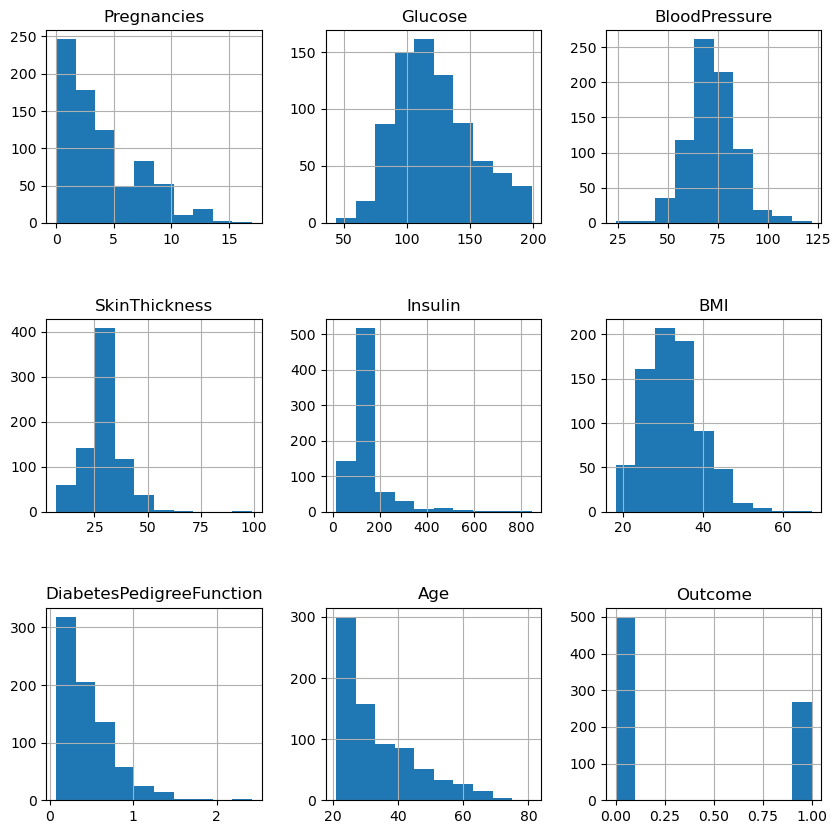

In [371]:
data_0s.hist(figsize=(10,10))
plt.subplots_adjust(hspace=0.5);

In [373]:
df = data_0s

In [375]:
print(df.isnull().any())

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool


In [377]:
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [379]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.000000,6.00000,17.00
Glucose,768.0,121.686763,30.435949,44.000,99.75000,117.000000,140.25000,199.00
BloodPressure,768.0,72.405184,12.096346,24.000,64.00000,72.202592,80.00000,122.00
SkinThickness,768.0,29.108073,8.791221,7.000,25.00000,29.000000,32.00000,99.00
Insulin,768.0,140.671875,86.383060,14.000,121.50000,125.000000,127.25000,846.00
BMI,768.0,32.457464,6.875151,18.200,27.50000,32.400000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.372500,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.000000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.000000,1.00000,1.00


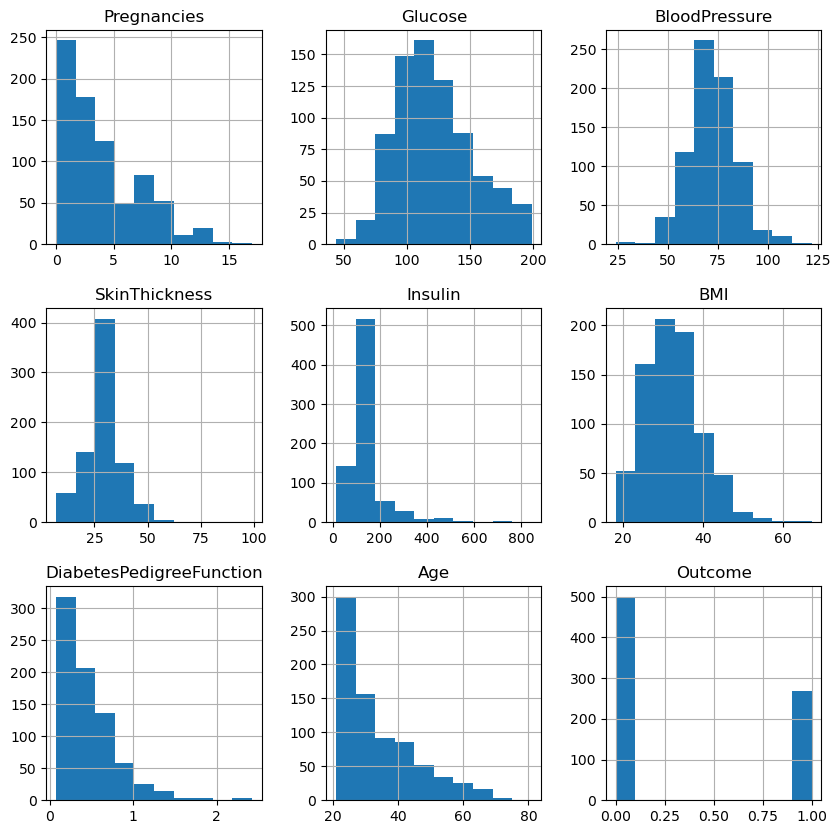

In [381]:
hist = df.hist(bins=10, figsize=(10,10))

In [383]:
print(df.dtypes)

Pregnancies                   int64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


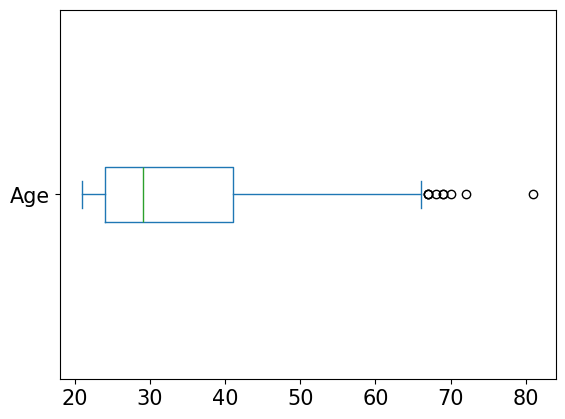

In [385]:
box_age = df['Age'].plot(kind='box', vert=False, fontsize=15)
plt.show()

^^^ I will not remove the age outliers. These are reasonable ages, just a bit older than the majority.

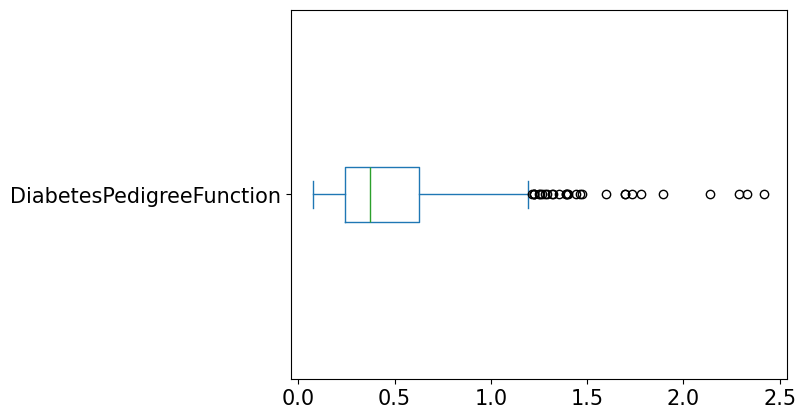

In [387]:
box_ped = df['DiabetesPedigreeFunction'].plot(kind='box', vert=False, fontsize=15)
plt.show()

^^^ I will not remove these outliers because the industry normal ranges for this variable are 0.08-2.42

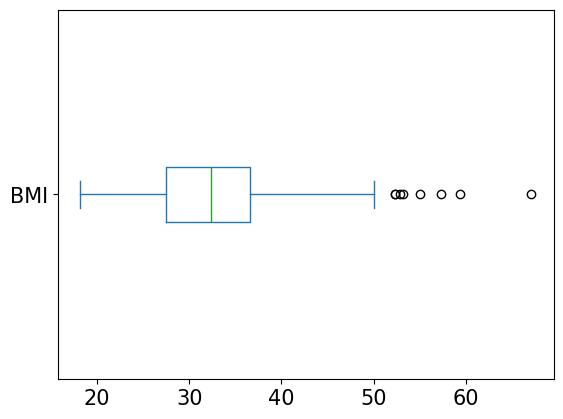

In [389]:
box_bmi = df['BMI'].plot(kind='box', vert=False, fontsize=15)
plt.show()

^^^ Any values above 40 would already be morbidly obese. I will remove the outliers as they're all above 50 which are exceptional.

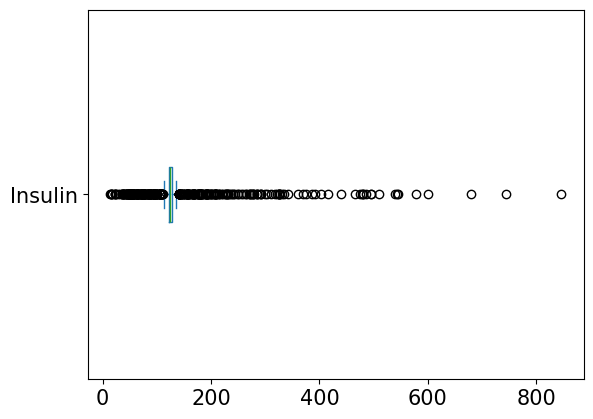

In [391]:
box_insulin = df['Insulin'].plot(kind='box', vert=False, fontsize=15)
plt.show()

^^^ I will remove the outliers above 250 to get closer to a "normal distribution of the data. I arrived at this number gradually-- starting at below 550 and chipping away further when I saw that removing the outliers didn't seem to hurt the distribution of the dependent variable, Outcome.

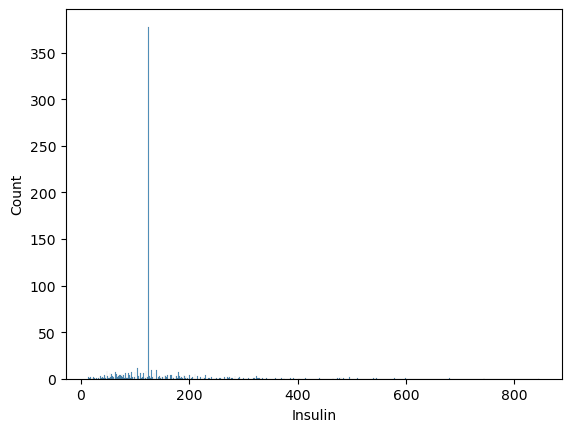

In [393]:
sns.histplot(df['Insulin'])
plt.show()

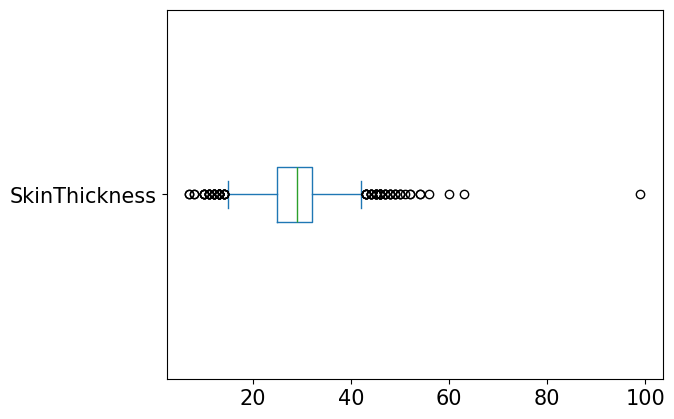

In [395]:
box_sT = df['SkinThickness'].plot(kind='box', vert=False, fontsize=15)
plt.show()

^^ I will remove outliers below 10 and above 55

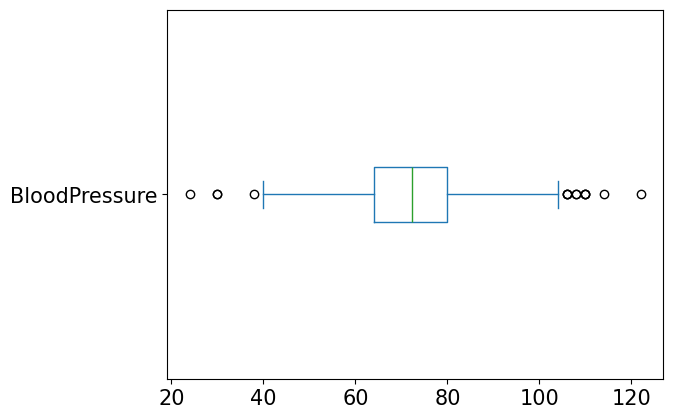

In [397]:
box_bp = df['BloodPressure'].plot(kind='box', vert=False, fontsize=15)
plt.show()

^^ I will remove outliers below 40 since those were likely recorded in error. It would be tough to believe a person would be alive with bp lower than that. I will also remove the 2 above 115 to bring a more "normal" distribution of the data.

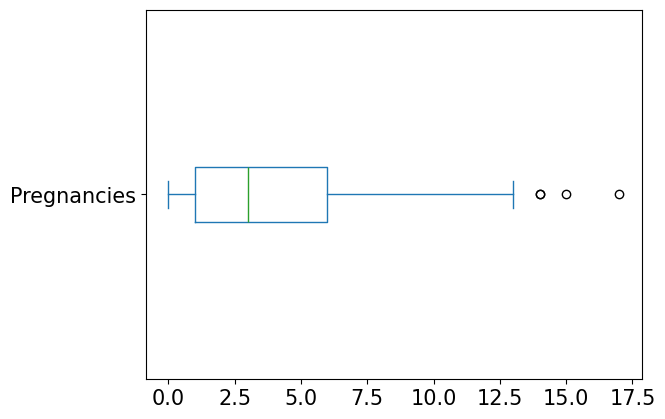

In [399]:
box_preg = df['Pregnancies'].plot(kind='box', vert=False, fontsize=15)
plt.show()

^^ I will remove outliers above 13

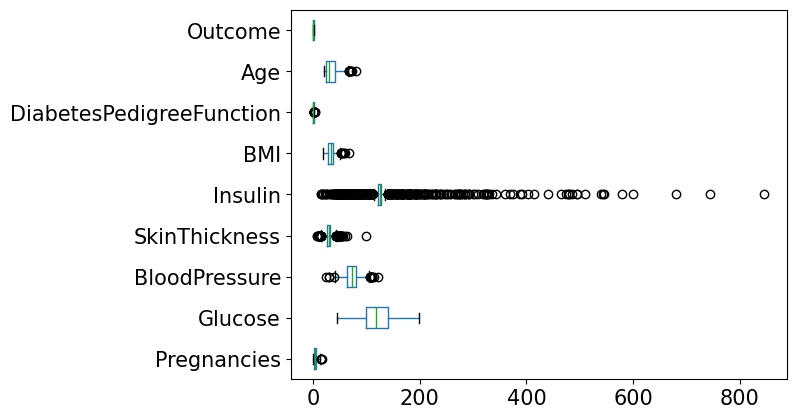

In [401]:
boxplot = df.boxplot(grid=False, vert=False, fontsize=15)

In [403]:
df['BMI'] = df['BMI'].where(df['BMI'] < 50)
df['BloodPressure'] = df['BloodPressure'].where((df['BloodPressure'] > 40) & (df['BloodPressure'] < 115))
df['Insulin'] = df['Insulin'].where(df['Insulin'] < 250)
df['SkinThickness'] = df['SkinThickness'].where((df['SkinThickness'] > 10) & (df['SkinThickness'] < 55))
df['Pregnancies'] = df['Pregnancies'].where(df['Pregnancies'] < 13)

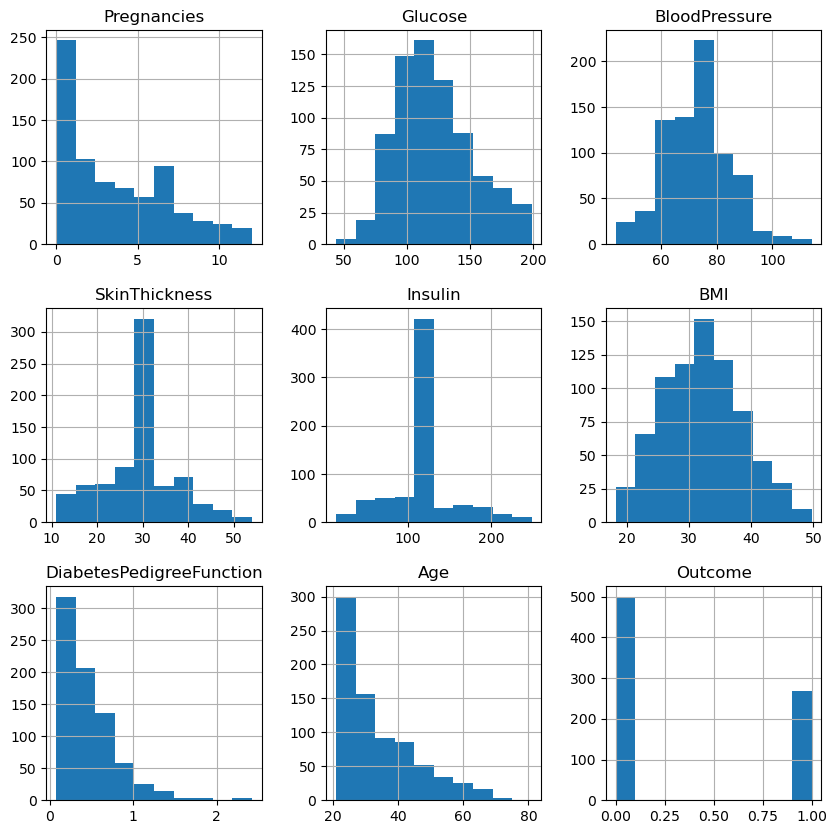

In [405]:
less_outliers = df.hist(bins=10, figsize=(10,10))

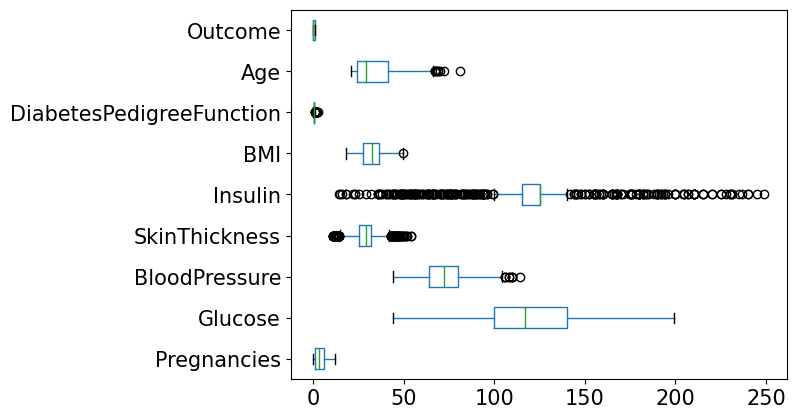

In [407]:
boxplot = df.boxplot(grid=False, vert=False, fontsize=15)

In [409]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

*** I will oversample the minority dependent variable (Outcome: 1) to balance the data set. I'm choosing this rather than undersampling the majority because the data set is not that big at only 768 people. If anything, it will be better to have a larger data set.

In [411]:
df.isnull().sum()

Pregnancies                 14
Glucose                      0
BloodPressure                6
SkinThickness               13
Insulin                     57
BMI                          9
DiabetesPedigreeFunction     0
Age                          0
Outcome                      0
dtype: int64

In [417]:
df['Pregnancies'] = df['Pregnancies'].fillna(df['Pregnancies'].median())
df['BloodPressure'] = df['BloodPressure'].fillna(df['BloodPressure'].mean())
df['SkinThickness'] = df['SkinThickness'].fillna(df['SkinThickness'].median())
df['Insulin'] = df['Insulin'].fillna(df['Insulin'].median())
df['BMI'] = df['BMI'].fillna(df['BMI'].mean())

In [419]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [421]:
from sklearn.utils import resample

majority = df[df.Outcome == 0]
minority = df[df.Outcome == 1]

minority_unsampled = resample(minority,
                              replace=True,
                              n_samples=len(majority),
                              random_state=16)
df_balanced = pd.concat([majority, minority_unsampled])
print(df_balanced['Outcome'].value_counts())
print(df_balanced)

Outcome
0    500
1    500
Name: count, dtype: int64
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin        BMI  \
1            1.0     85.0      66.000000           29.0    125.0  26.600000   
3            1.0     89.0      66.000000           23.0     94.0  28.100000   
5            5.0    116.0      74.000000           29.0    125.0  25.600000   
7           10.0    115.0      72.405184           29.0    125.0  35.300000   
10           4.0    110.0      92.000000           29.0    125.0  37.600000   
..           ...      ...            ...            ...      ...        ...   
280          0.0    146.0      70.000000           29.0    125.0  37.900000   
675          6.0    195.0      70.000000           29.0    125.0  30.900000   
125          1.0     88.0      72.602600           42.0     99.0  32.184232   
236          7.0    181.0      84.000000           21.0    192.0  35.900000   
719          5.0     97.0      76.000000           27.0    125.0  35.600000   


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0, 0.5, 'Pregnancies'),
  Text(0, 1.5, 'Glucose'),
  Text(0, 2.5, 'BloodPressure'),
  Text(0, 3.5, 'SkinThickness'),
  Text(0, 4.5, 'Insulin'),
  Text(0, 5.5, 'BMI'),
  Text(0, 6.5, 'DiabetesPedigreeFunction'),
  Text(0, 7.5, 'Age'),
  Text(0, 8.5, 'Outcome')])

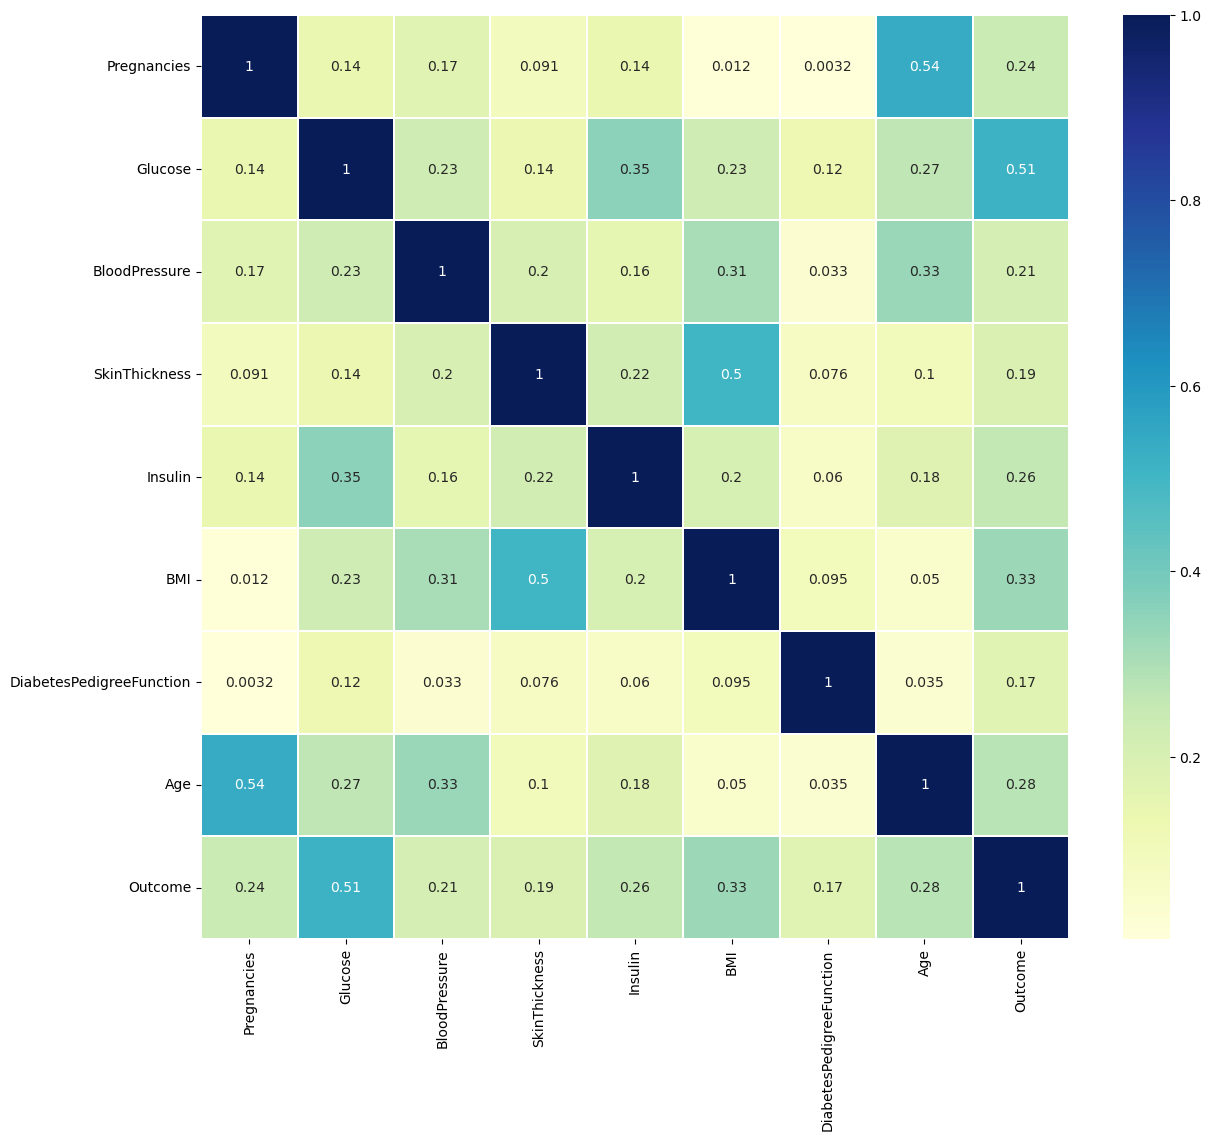

In [423]:
plt.figure(figsize=(14,12))
sns.heatmap(df_balanced.corr(), linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0)

In [425]:
df = df_balanced.reset_index(drop=True)
df['Outcome'].value_counts()

Outcome
0    500
1    500
Name: count, dtype: int64

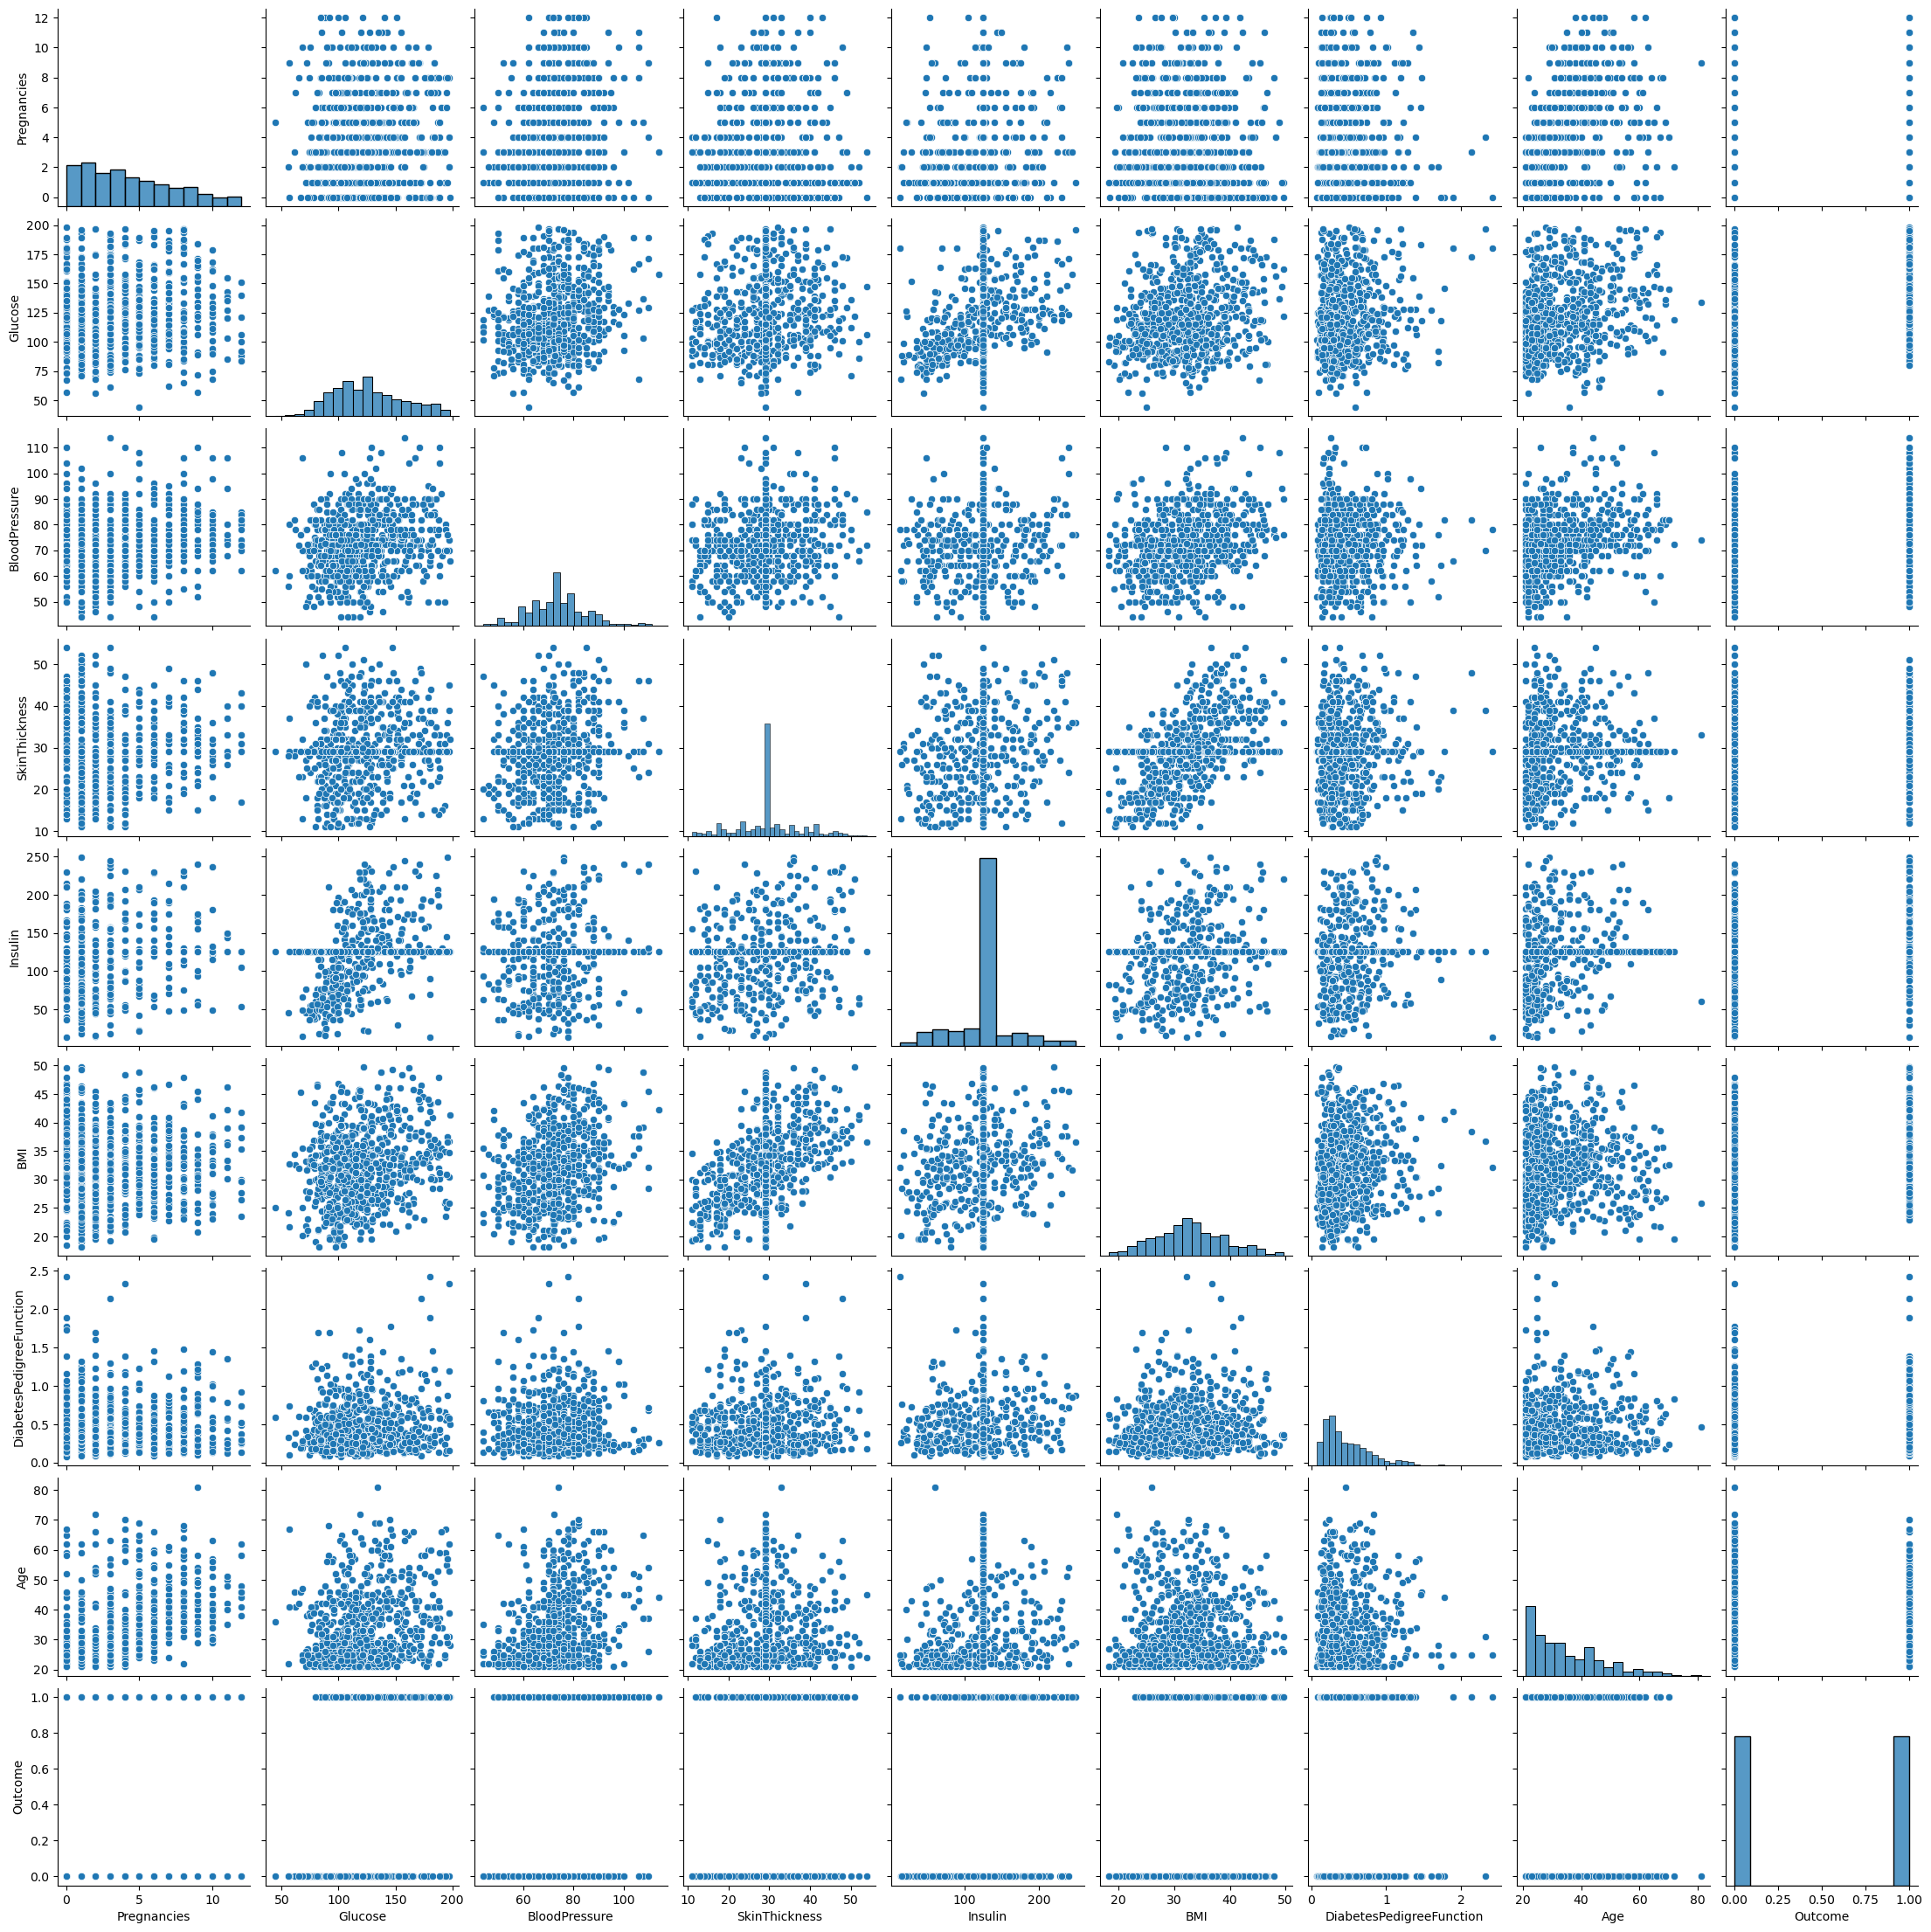

In [427]:
g = sns.pairplot(df)

In [429]:
from scipy.stats import pearsonr

list_all_ind = df[["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]]
list_outcome = df["Outcome"]
list_preg = df["Pregnancies"]
list_gluc = df["Glucose"]
list_bp = df["BloodPressure"]
list_skinthk = df["SkinThickness"]
list_insu = df["Insulin"]
list_bmi = df["BMI"]
list_diapedfunc = df["DiabetesPedigreeFunction"]
list_age = df["Age"]

In [431]:
corr_pregnancies = pearsonr(list_preg, list_outcome)
print(corr_pregnancies)

PearsonRResult(statistic=0.23778905185455967, pvalue=2.5426999829716203e-14)


In [433]:
corr_glucose = pearsonr(list_gluc, list_outcome)
print(corr_glucose)

PearsonRResult(statistic=0.5138558136262377, pvalue=1.7708334744820915e-68)


In [435]:
corr_bloodpressure = pearsonr(list_bp, list_outcome)
print(corr_bloodpressure)

PearsonRResult(statistic=0.21260941654932802, pvalue=1.1005631437190211e-11)


In [437]:
corr_skinthickness = pearsonr(list_skinthk, list_outcome)
print(corr_skinthickness)

PearsonRResult(statistic=0.19212769638963711, pvalue=9.059103998151679e-10)


In [439]:
corr_insulin = pearsonr(list_insu, list_outcome)
print(corr_insulin)

PearsonRResult(statistic=0.25727083381895227, pvalue=1.3974961576137778e-16)


In [441]:
corr_bmi = pearsonr(list_bmi, list_outcome)
print(corr_bmi)

PearsonRResult(statistic=0.32808345730737865, pvalue=1.5942722057466133e-26)


In [443]:
corr_diabetes_pedigree = pearsonr(list_diapedfunc, list_outcome)
print(corr_diabetes_pedigree)

PearsonRResult(statistic=0.17259786313765624, pvalue=3.963575539899524e-08)


In [445]:
corr_age = pearsonr(list_age, list_outcome)
print(corr_age)

PearsonRResult(statistic=0.2760552923043417, pvalue=5.998272158822642e-19)


***These results don't show much correlation at all. That's not surprising, however, since use of pearson r correlation assumes normal distribution which isn't the case for my dataset. My dependent variable is a binary Y/N on whether the person has diabetes.

In [447]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [449]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.0,85.0,66.000000,29.0,125.0,26.6,0.351,31,0
1,1.0,89.0,66.000000,23.0,94.0,28.1,0.167,21,0
2,5.0,116.0,74.000000,29.0,125.0,25.6,0.201,30,0
3,10.0,115.0,72.405184,29.0,125.0,35.3,0.134,29,0
4,4.0,110.0,92.000000,29.0,125.0,37.6,0.191,30,0


In [451]:
X, y = df[["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]], df["Outcome"]
y_binary = (y > np.median(y)).astype(int)

In [453]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [455]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

***I have scaled all the independent variables, as they were numeric. Had any of them been categorical, I would have created dummy variables on those. The dependent variable was binary, so no need to scale it, I just adjusted the type to integer. 

***Because my dependent variable is a binary Yes/No about diabetes diagnosis, I will do the 2 types of modeling recommended for this case-- Logistic regression and Support Vector Machine algorithms.

In [457]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression()

In [459]:
y_pred = logmodel.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 78.00%


***I tried out one example of logistic regression on it's own above & below tried it with hyperparameter tuning.

In [461]:
c_param_logreg_range = [0.001, 0.01, 0.1, 1, 10, 100]

table = pd.DataFrame(columns = ['c_param_logreg_range', 'accuracy'])
table['c_param_logreg_range'] = c_param_logreg_range

j=0
for i in c_param_logreg_range:
    logreg = LogisticRegression(penalty = 'l2', C = i, random_state = 123)
    logreg.fit(X_train, y_train)
    y_pred_lr = logreg.predict(X_test)
    table .iloc[j,1] = accuracy_score(y_test, y_pred_lr)
    j += 1

table

,c_param_logreg_range,accuracy
0,0.001,0.725
1,0.010,0.765
2,0.100,0.785
3,1.000,0.78
4,10.000,0.78
5,100.000,0.78


In [463]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
Accuracy_score_lr = logreg.score(X_test, y_test)
print("Accuracy Score", Accuracy_score_lr)

Confusion Matrix:
 [[81 15]
 [29 75]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.84      0.79        96
           1       0.83      0.72      0.77       104

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.79      0.78      0.78       200

Accuracy Score 0.78


In [465]:
from sklearn.model_selection import cross_val_score

cv_scores_test = cross_val_score(logreg, X_test, y_test, cv=2, scoring='roc_auc')
cv_scores_train = cross_val_score(logreg, X_train, y_train, cv=2, scoring='roc_auc')
print(cv_scores_test)
cv_scores_lr_test = cv_scores_test.mean()
cv_scores_lr_train = cv_scores_train.mean()
cv_scores_std_test_lr = cv_scores_test.std()
print('Mean cross validation test score: ' +str(cv_scores_lr_test))
print('Mean cross validation train score: ' +str(cv_scores_lr_train))
print('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))

[0.83133013 0.87379808]
Mean cross validation test score: 0.8525641025641025
Mean cross validation train score: 0.8465971597159716
Standard deviation in cv test scores: 0.02123397435897434


In [467]:
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

svm = SVC(kernel='rbf', gamma=0.5, C=1)
svm.fit(X_train, y_train)

y_predict_svm = svm.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_predict_svm)
print(cnf_matrix)

Accuracy_svm = svm.score(X_test, y_test)
print("Accuracy: ", Accuracy_svm)

[[83 13]
 [17 87]]
Accuracy:  0.85


In [469]:
from sklearn.model_selection import cross_val_score

cv_scores_test = cross_val_score(svm, X_test, y_test, cv=2, scoring='roc_auc')
cv_scores_train = cross_val_score(svm, X_train, y_train, cv=2, scoring='roc_auc')
print(cv_scores_test)
cv_scores_svm_test = cv_scores_test.mean()
cv_scores_svm_train = cv_scores_train.mean()
cv_scores_std_svm = np.std(cv_scores_test)
print('Mean cross validation test score: ' +str(cv_scores_svm_test))
print('Mean cross validation train score: ' +str(cv_scores_svm_train))
print('Standard deviation in cv scores: ' +str(cv_scores_std_svm))

[0.84214744 0.87740385]
Mean cross validation test score: 0.859775641025641
Mean cross validation train score: 0.875937593759376
Standard deviation in cv scores: 0.01762820512820512


*** Now I'll compare the models:

In [471]:
mylabels = ['Logistic Regression', 'SVM']
score_test = [cv_scores_lr_test, cv_scores_svm_test]
score_train = [cv_scores_lr_train, cv_scores_svm_train]
Accuracy_score = [Accuracy_score_lr, Accuracy_svm]

score_tab_acc = pd.DataFrame(list(zip(mylabels, Accuracy_score)),
                             columns = ['Algorithm', 'Model accuracy score'])

score_tab = pd.DataFrame(list(zip(mylabels, score_train, score_test)),
                         columns = ['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score'])
print(score_tab_acc)
score_tab

             Algorithm  Model accuracy score
0  Logistic Regression                  0.78
1                  SVM                  0.85


,Algorithm,ROC-AUC train score,ROC-AUC test score
0,Logistic Regression,0.846597,0.852564
1,SVM,0.875938,0.859776


*** SVM appears to be the better choice over Logistic Regression both the Accuracy and ROC-AUC scores are higher